# CTSegNet for Particle Analysis

**Use Case:** Glass Spheres dataset on TomoBank  

Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

https://tomobank.readthedocs.io/en/latest/source/data/docs.data.spheres.html

**NOTE** This notebook contains jupyter widgets that may not display unless you re-rerun the notebook.  

In [3]:
%matplotlib notebook

import sys
import os
import numpy as np
import pandas as pd
import glob
import h5py
import time

from scipy.ndimage.filters import median_filter
from ImageStackPy import Img_Viewer as VIEW

import matplotlib.pyplot as plt
import matplotlib as mpl

# from ct_segnet.data_utils import data_io
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
from ct_segnet import seg_utils
from tqdm import tqdm

from ct_segnet.data_utils import patch_maker_3D as PM3D
from ct_segnet.data_utils.data_io import Parallelize
from ct_segnet.seg_utils import Segmenter

from ImageStackPy import ImageProcessing as IP

# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display, update_display
from ipyfilechooser import FileChooser
from skimage.io import imread
from tomopy.misc.corr import remove_ring

def text_width(wd):
    return Layout(width = "%ipx"%wd)

In [3]:
# The model path should be the model_repo folder in the CTSegNet folder that you cloned from GitHub. If a model file is not found, please contact the author.  
model_path = '../model_repo/'
default_path = '../TomoBank/Glass/projs_rec/' #ensure this path matches where your data is located.

**Load some models into memory.**  

In [3]:
global segmenters
segmenters = {}
model_list = glob.glob(os.path.join(model_path,'*.hdf5'))
model_list = [os.path.split(model_item)[-1] for model_item in model_list]


model_dropdown = widgets.Dropdown(description = 'model_name', options = model_list)
btn_0 = widgets.Button(description = "Load")
status1 = widgets.Label(description = 'progress', value = "")
display(HBox(children = [model_dropdown, btn_0, status1]))

def get_segmenter(obj):
    status1.value = "loading..."
#     global segmenter
    if model_dropdown.value.split(".hdf5")[0] not in segmenters.keys():
        segmenter = seg_utils.Segmenter(model_filename = os.path.join(model_path, model_dropdown.value))
        segmenters.update({segmenter.model_name : segmenter})
    status1.value = "done"
    return

btn_0.on_click(get_segmenter)

In [4]:
# this file is not available on GitHub. Replace it with model_repo/models.csv
df = pd.read_csv(os.path.join(model_path, "model_manager/SNR_studies.csv"))
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 1000)
df

,name,description,notes-SNR
0,M_a01_242_512,First model trained on metal samples in limited-ROI mode with focal loss,fall-off below SNR < 10 (!?)
1,M_a02_242_512,Trained on metal samples with Binary cross-entropy loss (for comparison with FL),no fall-off
2,M_b01_242_512,Trained with focal loss on quartz / sapphire samples,fall-off at SNR > 10 (!?)
3,M_b02_242_512,"for phase contrast CT, noise and phase contrast synthetically added",fall-off below SNR < 2
4,M_b03_242_512,"for phase contrast CT, noise and phase contrast synthetically added",NaN
5,M_c01_222_256,Trained on steel samples with synthetically added noise,NaN
6,M_c02_222_256,Trained on steel samples with synthetically added phase contrast,fall-off below SNR < 8 - phase-contrast confuses
7,M_d02_222_256,"Trained on foam phantoms with missing wedge, ring artifacts and sparse angles",NaN


#### Choice of model:
The above is a list of models in the repository. Let's pick M_c02 which is the best model that works on phase-contrast CT data.


In [5]:
# You will need to install ImageStackPy from my GitHub. it's a library for mimicing ImageJ in Python
def fpreprocess(img):
    
#     img = IP.XY_medianBlur(img, X_kern_size = 3)[0]
    img[np.isnan(img)] = 0
    h = IP.modified_autocontrast(img, s = 0.001)
    img = np.clip(img, *h)
#     img = IP.XY_gaussianBlur(img, X_kern_size = 7)[0]

    if text_axis.value == 0:
        img = remove_ring(img[np.newaxis,...])[0]

    return img
    

## Try out different patch-extraction strategies  
You select two parameters:  
n_patches or max_patches - this is a tuple (y,x). y is the number of patches along y, etc.  
overlap - this the number of pixels overlapping between patches. Just pick 20 and go with it.  
**Note to user:** In CTSegNet, the arguments max_patches and n_patches mean the same thing. In the future, the alias max_patches will be removed.  

**IMPORTANT** Notebook widgets may not display correctly unless you re-run the notebook at your end.  

FileChooser(path='/data02/MyArchive/TomoBank/Glass/projs_rec', filename='', show_hidden='False')

['',
 'Dataset shape: (2160, 2560, 2560)',
 'Dataset size: 14.16 GB',
 'Chunk shape: (56, 66, 66)',
 'Slice size along 0: 6.55 MB',
 'Slice size along 1: 5.53 MB',
 'Slice size along 2: 5.53 MB']

<IPython.core.display.Javascript object>


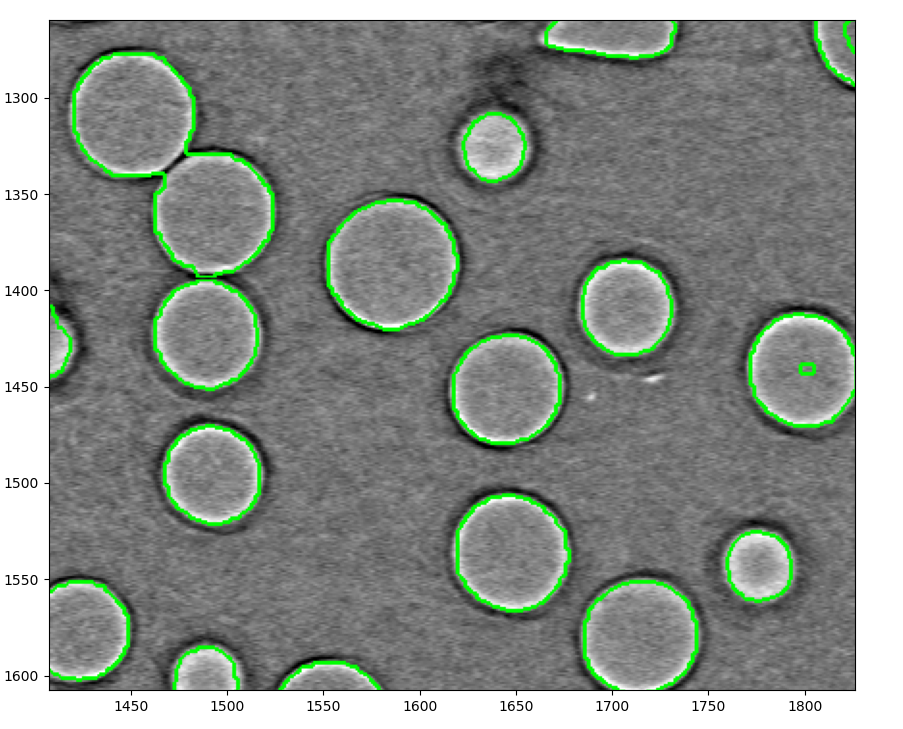

In [6]:
# file selector
fc = FileChooser(default_path)
btn_fc = widgets.Button(description = "Load DataSet")
checkbox_fc_seg = widgets.Checkbox(description = "This is a Segmentation Mask")

display(fc)
display(HBox(children = [btn_fc, checkbox_fc_seg]))
display("", display_id = "007")

def load_ds(obj):
    if checkbox_fc_seg.value:
        global ds_seg
        ds_seg = DataFile(fc.selected, data_tag = "SEG", tiff = False, VERBOSITY = 0)
        str_out = ds_seg.show_stats(return_output = True).split('\n')
    else:
        global ds
        ds = DataFile(fc.selected, data_tag = "data", tiff = False, VERBOSITY = 0)
        str_out = ds.show_stats(return_output = True).split('\n')
    
    "<br>".join(str_out)
    update_display(str_out, display_id = "007")
    
    return
btn_fc.on_click(load_ds)

# model selector
ddown_mselect = widgets.Dropdown(description = "select model: ", options = segmenters.keys(), value = list(segmenters.keys())[0])
is_pp = widgets.Checkbox(description = "Preprocess Image")
display(HBox(children = [ddown_mselect, is_pp]))
def select_model(obj):
    global segmenter
    segmenter = segmenters[ddown_mselect.value]
    return
ddown_mselect.observe(select_model)
select_model(None)


# slice reader
text_axis = widgets.IntText(description = "axis", min = 0, max = 2, value = 0, layout = text_width(150))
slider = widgets.IntSlider(description = "slider", min = 0, value = 0, step = 1)
display(HBox(children = [text_axis, slider]))

# segmenter parameters
text_np = [widgets.IntText(description = "axis %i"%i, value = 3, layout = text_width(150)) for i in range(2)]
text_cropX = [widgets.IntText(description = "cropX %s"%_str, layout = text_width(150)) for _str in ["start", "end"]]
text_cropY = [widgets.IntText(description = "cropY %s"%_str, layout = text_width(150)) for _str in ["start", "end"]]
btn_seg = widgets.Button(description = "Segment")
load_btn_1 = widgets.Button(description = "Load Image")
checkbox_edge = widgets.Checkbox(description = "Edge Plot", value = True)
display(HBox(children = text_np + text_cropY + text_cropX))
display(HBox(children = [load_btn_1, btn_seg, checkbox_edge]))

fig, ax = plt.subplots(1,1, figsize = (6,6))
fig.tight_layout()

def load_image(obj):
    global img_in
    img_in = ds.read_slice(axis = text_axis.value, slice_idx = slider.value)

    if is_pp.value:
        img = fpreprocess(img_in.copy())
    else:
        img = img_in.copy()
    
    ax.clear()
    ax.imshow(img, cmap = 'gray')
    return

def seg_shower(obj):
    
    if is_pp.value:
        img = fpreprocess(img_in.copy())
    else:
        img = img_in.copy()
    
    
    if checkbox_fc_seg.value:
        seg_img = ds_seg.read_slice(axis = text_axis.value, slice_idx = slider.value)
    else:
        n_patches = (text_np[0].value, text_np[1].value)

        slice_y = slice(text_cropY[0].value, text_cropY[1].value)
        slice_x = slice(text_cropX[0].value, text_cropX[1].value)

        seg_img = np.zeros_like(img, dtype = np.uint8)
        seg_img[slice_y,slice_x] = segmenter.seg_image(img[slice_y,slice_x], max_patches = n_patches, overlap = 20)
    
    if checkbox_edge.value:
        viewer.edge_plot(img, seg_img, ax)
    else:
        viewer.seg_plot(img, seg_img, ax)
    fig.tight_layout()
    return

btn_seg.on_click(seg_shower)
load_btn_1.on_click(load_image)


def update_slider(obj):
    slider.max = ds.d_shape[text_axis.value]
    
    if text_axis.value == 0:
        i, j = 1,2
    elif text_axis.value == 1:
        i, j = 0,2
    elif text_axis.value == 2:
        i, j = 0,1
    
    for k in range(2):
        text_cropY[k].min = 0
        text_cropY[k].max = ds.d_shape[i]
        text_cropX[k].min = 0
        text_cropX[k].max = ds.d_shape[j]
    text_cropX[0].value = 0
    text_cropY[0].value = 0
    text_cropX[1].value = text_cropX[1].max
    text_cropY[1].value = text_cropY[1].max
        
    return
text_axis.observe(update_slider)


btn_fc.on_click(update_slider)


In [7]:
print("Current dataset: %s"%ds.fname)

Current dataset: /data02/MyArchive/TomoBank/Glass/projs_rec/tomo_00058_rec.hdf5


------------------
### Pre-process data
Write a pre-processing script to apply any additional filters to the recon data. In this case,  
1. apply tomopy.prep.remove_ring() along axis 0  
2. apply auto-contrast adjustment (s = 0.001)  

This script must be saved as 'preprocessor.py' and contain a function 'preprocessor(vol)'. It is shown below.

```python
import time
import sys
import numpy as np
from ct_segnet.data_utils.data_io import DataFile
from ImageStackPy.ImageProcessing import modified_autocontrast
from tomopy.misc.corr import remove_ring

contrast_s = 0.001
def preprocessor(vol):
    """
    Preprocessing function.
    Parameters
    ----------
    vol : np.array
        3D tomo reconstructed volume
    Returns
    -------
    np.array
        pre-processed tomo volume
    
    """
    t_pp = time.time()
    # Apply remove ring
    print("\tApplying tomopy remove_ring")
    vol = remove_ring(vol)
    print("\t\tElapsed time: %.2f seconds"%(time.time() - t_pp))

    # Apply auto-contrast
    print("\tApplying auto-contrast adjustment, s = %.4f"%contrast_s)
    
    vol[np.isnan(vol)] = 0 # remove nans
    h = modified_autocontrast(vol[::3,::3,::3], s = 0.001) # get contrast values to clip, use 3x down-sampled array
    vol = np.clip(vol, *h) # h is a tuple of min and max values
    tot_time_pp = (time.time() - t_pp)/60.0
    print("\t\tTotal pre-processing time: %.2f minutes"%tot_time_compute)
    return vol
```

------------------
### Post-process binary mask: Morphological Filters
Write a function to apply morphological filters on the ensemble vote mask (erode-dilate) 

This script must be saved as 'morpho.py' and contain a function 'morpho_filter()'. It is shown below.

```python
def morpho_filter(vol, ops = ["erode", "dilate"], radius = [5, 5], output = None, crops = None):
    """
    this removes tessellation artifacts
    Parameters
    ----------
    vol : np.array
        binary (labeled) volume; can also be a 2D image
    ops : list
        list of operations - pick from "erode" and "dilate"
    radius : radius or list of radii for the respective operations
    
    Returns
    -------
    np.array
        filtered binary (labeled) volume
    """
    
    if crops is not None:
        pads = get_repadding(crops, vol.shape)
        vol = vol[slice(*crops[0]), slice(*crops[1]), slice(*crops[2])]
    
    print("Morphological operations: ")
    if type(radius) is not list:
        radius = [radius]*len(ops)
    
    t00 = time.time()
    for idx, op in enumerate(ops):
        t0 = time.time()
        struct = make_binary_structure(radius[idx], ndim = vol.ndim)
        
        print("%s (r = %i),"%(op, radius[idx]), end = " ")
        if op == "erode":
            vol = binary_erosion(vol, structure = struct, output = output)
        elif op == "dilate":
            vol = binary_dilation(vol, structure = struct, output = output)
        t_step = time.time() - t0
        print("%.1f secs; "%t_step, end = " ")
    
    # Pad the volume to bring it back to original dimensions
    if crops is not None:
        vol = np.pad(vol, pads, 'constant', constant_values = 0)
    
    tot_time = (time.time() - t00)/60.0
    print("\ntotal time = %.2f minutes"%tot_time)
    return vol

```

***
### Prepare Config File  
Note down the parameters for an odd number of most accurate masks, then write them into the config file.  


```bash
[FILE PATHS]
ct_fpath = /data02/MyArchive/TomoBank/Glass/projs_rec/tomo_00058_rec.hdf5
ct_data_tag = data
seg_path = /data02/MyArchive/TomoBank/Glass/CTSegNet_masks
model_path = /home/atekawade/DataArchive3/Deep_Segmenting/model_repo
model_name = M_c02_222_256
vote_maskname = tomo_00058_VOTE01

[DEFAULTS]
stats_only = False
remove_masks = True
run_ensemble = True
run_seg = True
mem_thres = 5.0 # amount of data to be read from ct data at a time. Only applies to ensemble vote step.
overwrite_OK = True # if mask name already exists, overwrite.
rw_verbosity = 0 # 0 - silent, 1 - important stuff, 2 - everything
tiff_output = False # if True, final mask is output as tiff sequence
mpl_agg = Agg

[ADVANCED]
nprocs = 1 # for seg_chunk() - use these many processors on each subset of chunk
arr_split = 1 # for seg_chunk() - break down read chunk into these many subsets to process


[PRE-PROCESSING]
preprocess = True

[SEG PARAMETERS]
mask_name = [mask01, mask02, mask03] # three passes will generate three individual masks
slice_axis = [0, 1, 2] # three passes along Z, Y and X (0, 1, and 2) axes respectively
n_patches = [(3x3), (3x3), (3x3)] # for each pass, the full slice will be extracted into 9 patches (3x3)
overlap = [20, 20, 20] # overlap of 20 pixels between neighboring patches
rotation = [0, 0, 0] # you can rotate the volume before extracting patches
crops = [(300:None), (500:2100), (500:2100)] # crop the volume to ignore voxels outside of the physical sample


[MORPHOLOGICAL FILTERS]
morpho_filt = True
ops = [erode, dilate, erode, dilate]
#radius = [3,4,3]
radius = [3, 2, 5, 4]
invert_mask = True
```

***
### Run the 3D segmenter script  
Then run this script in the terminal. Output is shown below for a 12-core Intel Xeon (4 threads per core). You can see the memory utilization in the preprocessor function using *memory_profiler*. You may need to install it via pip. https://pypi.org/project/memory-profiler/  

**Comment** Notice that the RAM consumption doubles during the remove_ring step. This is because a copy of the tomo volume is being made rather than an in-place operation.


```bash
foo@bar:~$ python -m memory_profiler run_segmenter.py -c ../CTSegNet_masks/tomo_00058.cfg
```  

---  

The output from this code is shown below:  


```bash
############################################################

	Welcome to CTSegNet: AI-based 3D Segmentation

############################################################


Dataset shape: (2160, 2560, 2560)
Dataset size: 56.62 GB
Chunk shape: (56, 66, 66)
Slice size along 0: 26.21 MB
Slice size along 1: 22.12 MB
Slice size along 2: 22.12 MB

Starting segmentation mode ...
Reading CT volume into memory...
	Preprocessing volume...
	Applying tomopy remove_ring
		Elapsed time: 267.79 seconds
	Applying auto-contrast adjustment, s = 0.0010
		Total pre-processing time: 5.67 minutes

Working on mask01


DONE on Sat Oct 10 04:22:57 2020
Total time for generating mask01 mask: 4.20 minutes

Working on mask02


DONE on Sat Oct 10 04:26:39 2020
Total time for generating mask02 mask: 3.70 minutes

Working on mask03


DONE on Sat Oct 10 04:34:01 2020
Total time for generating mask03 mask: 7.36 minutes

Starting ensemble mode ...

100%|████████████████████████████████████████████████████████████████████████| 2160/2160 [10:02<00:00,  3.58it/s]

DONE on Sat Oct 10 04:44:04 2020
Total time for ensemble mask tomo_00058_VOTE01 : 10.05 minutes
Intermediate masks will be removed.

Applying morphological operations on ensemble vote...
Inverting mask...
Morphological operations: 
erode (r = 3), 152.9 secs;  dilate (r = 2), 294.5 secs;  erode (r = 5), 347.6 secs;  dilate (r = 4), 1758.9 secs;  
total time for morphological ops = 42.72 minutes

############################################################

	Total time elapsed for script: 76.00 minutes

############################################################

Filename: /data02/MyArchive/TomoBank/Glass/spheres/preprocessor.py

Line #    Mem usage    Increment   Line Contents
================================================
    21 55753.141 MiB 55753.141 MiB   @profile
    22                             def preprocessor(vol):
    23                                 """
    24                                 Preprocessing function.
    25                                 Parameters
    26                                 ----------
    27                                 vol : np.array
    28                                     3D tomo reconstructed volume
    29                                 Returns
    30                                 -------
    31                                 np.array
    32                                     pre-processed tomo volume
    33                                 
    34                                 """
    35 55753.141 MiB    0.000 MiB       t_pp = time.time()
    36                                 # Apply remove ring
    37 55753.141 MiB    0.000 MiB       print("\tApplying tomopy remove_ring")
    38 110959.062 MiB 55205.922 MiB       vol = remove_ring(vol)
    39 110959.062 MiB    0.000 MiB       print("\t\tElapsed time: %.2f seconds"%(time.time() - t_pp))
    40                             
    41                                 # Apply auto-contrast
    42 110959.062 MiB    0.000 MiB       print("\tApplying auto-contrast adjustment, s = %.4f"%contrast_s)
    43                                 
    44 110959.070 MiB    0.008 MiB       vol[np.isnan(vol)] = 0 # remove nans
    45 110959.199 MiB    0.129 MiB       h = modified_autocontrast(vol[::3,::3,::3], s = 0.001) # get contrast values to clip, use 3x down-sampled array
    46 110959.199 MiB    0.000 MiB       vol = np.clip(vol, *h) # h is a tuple of min and max values
    47 110959.199 MiB    0.000 MiB       tot_time_pp = (time.time() - t_pp)/60.0
    48 110959.199 MiB    0.000 MiB       print("\t\tTotal pre-processing time: %.2f minutes"%tot_time_pp)
    49 110959.199 MiB    0.000 MiB       return vol


Filename: /data02/MyArchive/TomoBank/Glass/spheres/morpho.py

Line #    Mem usage    Increment   Line Contents
================================================
    33 84216.773 MiB 84216.773 MiB   @profile
    34                             def morpho_filter(vol, ops = ["erode", "dilate"], radius = [5, 5], output = None, crops = None, invert_mask = False):
    35                                 """
    36                                 this removes tessellation artifacts
    37                                 Parameters
    38                                 ----------
    39                                 vol : np.array
    40                                     binary (labeled) volume; can also be a 2D image
    41                                 ops : list
    42                                     list of operations - pick from "erode" and "dilate"
    43                                 radius : radius or list of radii for the respective operations
    44                                 invert_mask : bool
    45                                     boolean True if mask must be inverted before filters applied
    46                                 
    47                                 Returns
    48                                 -------
    49                                 np.array
    50                                     filtered binary (labeled) volume
    51                                 """
    52                             
    53 84216.773 MiB    0.000 MiB       if invert_mask:
    54 84216.773 MiB    0.000 MiB           _message("Inverting mask...")
    55 97716.664 MiB 13499.891 MiB           vol = vol^1 # invert the labels if required by user. Some models interpret features as voids rather than particles and vice versa.
    56                                 
    57 97716.664 MiB    0.000 MiB       if crops is not None:
    58 97716.664 MiB    0.000 MiB           pads = get_repadding(crops, vol.shape)
    59 97716.664 MiB    0.000 MiB           vol = vol[slice(*crops[0]), slice(*crops[1]), slice(*crops[2])]
    60                                 
    61 97716.664 MiB    0.000 MiB       print("Morphological operations: ")
    62 97716.664 MiB    0.000 MiB       if type(radius) is not list:
    63                                     radius = [radius]*len(ops)
    64                                 
    65 97716.664 MiB    0.000 MiB       t00 = time.time()
    66 97716.664 MiB    0.000 MiB       for idx, op in enumerate(ops):
    67 97716.664 MiB    0.000 MiB           t0 = time.time()
    68 97716.824 MiB    0.160 MiB           struct = make_binary_structure(radius[idx], ndim = vol.ndim)
    69                                     
    70 97716.824 MiB    0.000 MiB           print("%s (r = %i),"%(op, radius[idx]), end = " ")
    71 97716.824 MiB    0.000 MiB           if op == "erode":
    72 88757.883 MiB    0.000 MiB               vol = binary_erosion(vol, structure = struct, output = output)
    73 88757.883 MiB    0.000 MiB           elif op == "dilate":
    74 88757.891 MiB    0.008 MiB               vol = binary_dilation(vol, structure = struct, output = output)
    75 88757.891 MiB    0.000 MiB           t_step = time.time() - t0
    76 88757.891 MiB    0.000 MiB           print("%.1f secs; "%t_step, end = " ")
    77                                 
    78                                 # Pad the volume to bring it back to original dimensions
    79 88757.891 MiB    0.000 MiB       if crops is not None:
    80 97716.875 MiB 8958.984 MiB           vol = np.pad(vol, pads, 'constant', constant_values = 0)
    81                                 
    82 97716.875 MiB    0.000 MiB       tot_time = (time.time() - t00)/60.0
    83 97716.875 MiB    0.000 MiB       print("\ntotal time for morphological ops = %.2f minutes"%tot_time)
    84 97716.875 MiB    0.000 MiB       return vol

```

## Domain-specific analysis: e.g. Particle Size Histogram

Now that we have generated a labeled mask where 1s represent the inside of the particle and 0s represent the background, we can perform a particle-size analysis by disconnecting the particles with connected component filter. The scipy.ndimage library is the module we need to run this analysis. The results will be more accurate if the segmentation is improved and most the particles are disconnected correctly.  

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.histogram.html  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html  


In [4]:
from scipy.ndimage import label, find_objects
ds_m = DataFile("../CTSegNet_masks/tomo_00058_VOTE01.hdf5", tiff = False, data_tag = "SEG", VERBOSITY = 0)
vol = ds_m.read_full()

In [5]:
vol_l, n_objs = label(vol)
obj_list = find_objects(vol_l)

In [6]:
print("Detected a total of %i particles"%n_objs)

Detected a total of 4113 particles


<IPython.core.display.Javascript object>


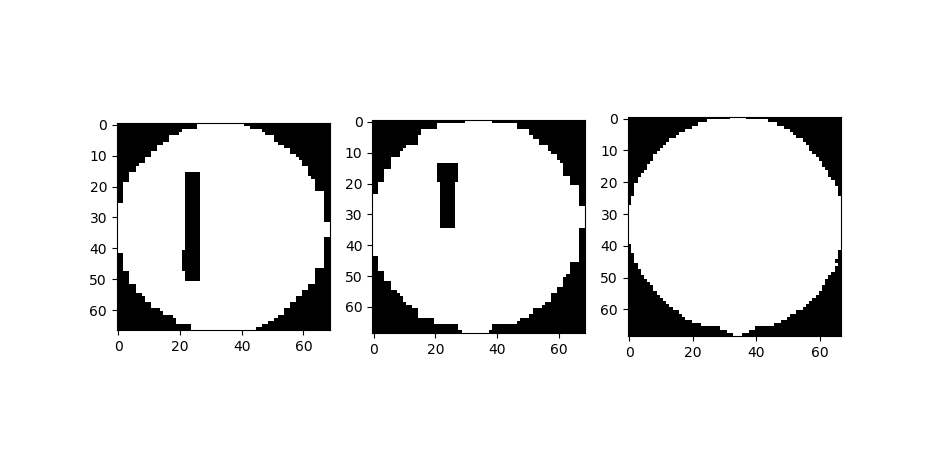

(69, 67, 69)


In [25]:
idx = 1700
sub_vol = vol_l[obj_list[idx]]
h = viewer.view_midplanes(sub_vol == (idx+1))
print(sub_vol.shape)

There is a segmentation artifact inside of the spherical particle. This will incorrectly decrease the measured particle size.

<IPython.core.display.Javascript object>


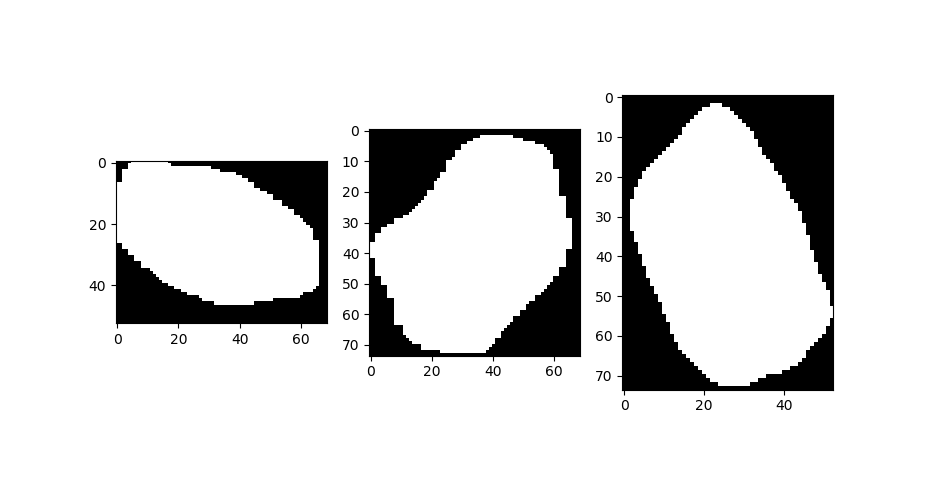

(74, 53, 69)


In [15]:
idx = 1702
sub_vol = vol_l[obj_list[idx]]
h = viewer.view_midplanes(sub_vol == (idx+1))
print(sub_vol.shape)

The label 1702 shows a particle with a non-spherical shape (these are three orthogonal views of the volume).

<IPython.core.display.Javascript object>


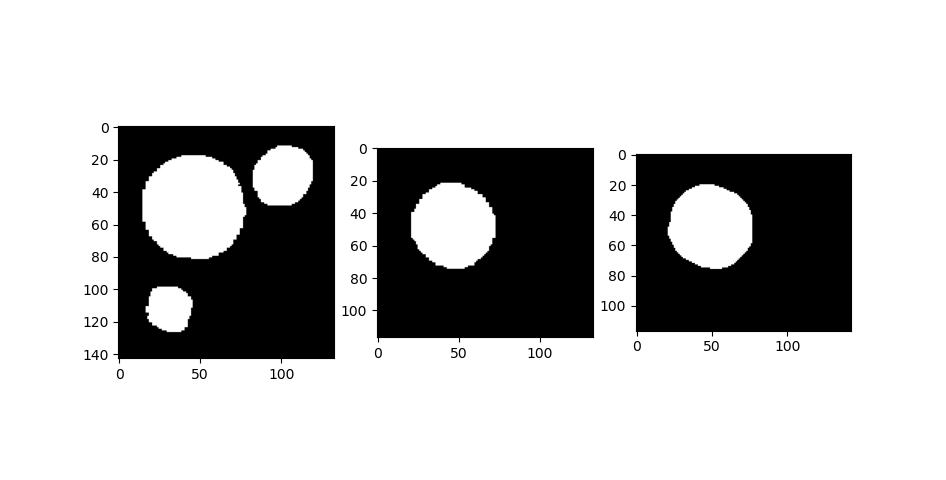

(117, 143, 133)


In [19]:
idx = 1701
sub_vol = vol_l[obj_list[idx]]
h = viewer.view_midplanes(sub_vol == (idx+1))
print(sub_vol.shape)

The label 1702 shows three particles connected to each other. The size calculation will be incorrect for these label. There is scope for improvement for the segmentation.  

In [20]:
# from ImageStackPy import Img_Viewer as VIEW
# VIEW.viewer(sub_vol == (idx + 1))

In [21]:
# p_vol = sub_vol.sum()/(idx+1)
p_vol = sub_vol==(idx+1)
p_vol = p_vol.sum()
p_dia_px = np.cbrt(p_vol)#*2*3/(4*np.pi)
print("particle volume = %.2f"%p_vol)
print("particle diameter = %.2f px"%p_dia_px)
p_dia = p_dia_px*0.65
print("particle diameter = %.2f mu"%p_dia)

particle volume = 416208.00
particle diameter = 74.66 px
particle diameter = 48.53 mu


In [23]:
from tqdm import trange

p_size = []
for idx in trange(n_objs):
    
    if idx < 5:
        continue
    
    sub_vol = vol_l[obj_list[idx]]
    
    p_vol = sub_vol==(idx+1)
    p_vol = p_vol.sum()
    p_dia_px = np.cbrt(p_vol)#*2*3/(4*np.pi)
    p_dia = p_dia_px*0.65
    
#     if np.cbrt(sub_vol.size) < 35:
#         continue
    p_size.append(p_dia)
    
p_size = np.asarray(p_size)    

100%|██████████| 4113/4113 [00:07<00:00, 531.84it/s]


<IPython.core.display.Javascript object>


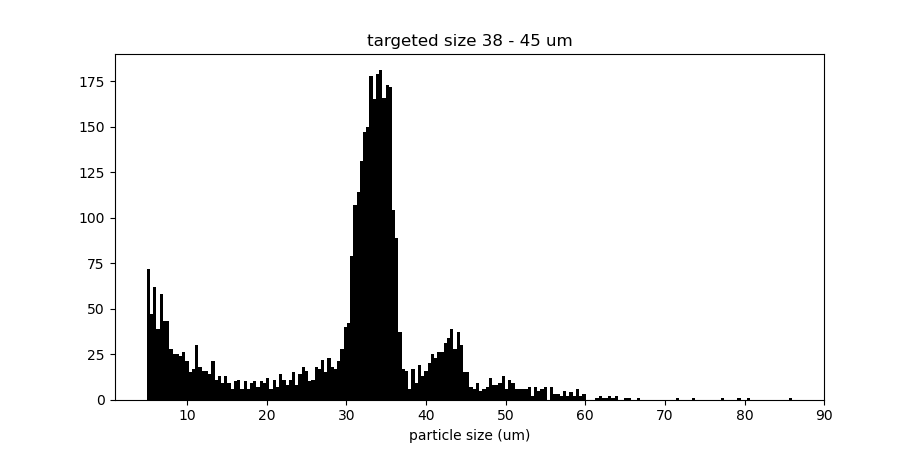

Text(0.5, 1.0, 'targeted size 38 - 45 um')

In [24]:
fig, ax = plt.subplots(1,1)
h = ax.hist(p_size, bins = 200, color = 'black')
ax.set_xlabel("particle size (um)")
band_h = h[0].max()
ax.set_title("targeted size 38 - 45 um")

You will notice that there three modes in this histogram. The smaller modes below 20 um and between 40 - 50 um could be due to segmentation artifacts and connected particles respectively. We need to dig into this further to improve the accuracy.

### Re-training Workflow (Comments)
The next step would be to improve the Unet-like fCNN model used above by re-training it on data processed above. This way, the pre-processing, ensemble vote and morphological filtering steps can be skipped for future segmentations. More on re-training in another notebook.

<img src="CTSegNet_continuouslearning.png">

The end!